 ![CellphoneDB Logo](https://www.cellphonedb.org/images/cellphonedb_logo_33.png) CellphoneDB

# CellPhoneDB involving novel epithelial and stromal cell states
## Using method 3 (differential expression)  

Here we use the method 3 (`degs_analysis_method`) to study how cell-cell interactions change between endometrial cells as epithelia and stromal cells differentiate in response to ovarian hormones:
- Proliferative endometium = before ovulation ~ estrogen only
- Secretory endometrium = after ovulation ~ estrogen & progesterone



Because cells are compartimentalised into endometrial regions (lumer or surface; functional layer or middle; and basal or bottom), we can restrict the analysis to spacially co-localised cells (i.e. cells in the same region or microenvironemt).  If we take into account temporal dynamics as well, we have more spatio-temporal **microenvironments**.

Here we are interested on new celltypes dicovered in our Mareckova study:
a) The SOX9 basalis epithelial cell - which shares spatiotemporal space with eStromal and basalis fibroblasts - PRoliferative_basalis microenviromnment.
b) The epithelial and stromal subsets in the three decidualisation stages: secreotry early, mid and late.


This notebook will retrieve interactions:
- between cell types in the same microenvironemt.
- where at least one of the interacting partners (genes involved in the interaction) is differentially expressed in either epithelial or stromal cells as they differentiate in secretory endoemtrium. We provide the differentially expressed genes, that we computed using lineage-based hierarchical clustering (i.e. differential expression within lineage). This is to identify the genes differentially expressed within each lineage (epithelials or stromal/fibroblasts) and capture the genes that change along their differentiation into secretory phase cells.




### Check python version

In [1]:
import pandas as pd
import numpy as np
import sys
import os

pd.set_option('display.max_columns', 100)
# Define our base directory for the analysis
os.chdir('/home/jovyan/cpdb_tutorial')

Checking that environment contains a Python >= 3.8 as required by CellPhoneDB.

In [2]:
print(sys.version)

3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]


___
## Input files
The differential expression method accepts 5 input files (4 mandatory).
- **cpdb_file_path**: (mandatory) path to the database.
- **meta_file_path**: (mandatory) path to the meta file linking cell barcodes to cluster labels.
- **counts_file_path**: (mandatory) paths to normalized counts file (not z-transformed), either in text format or h5ad (recommended).
- **degs_file_path**: (mandatory) path to the DEG file indicating the differentially expressed genes in each cluster. Only differentially expressed genes that are significant should be included.
- **microenvs_file_path** (optional) path to microenvironment file that groups cell types/clusters by microenvironments. When providing a microenvironment file, CellphoneDB will restrict the interactions to those cells within the microenvironment.

Both, `degs_file_path` and `microenvs_file_path` content will depend on the biological question that the researcher wants to answer.


> In **this example** we are studying how cell-cell interactions change between endometrial cells as epithelia and stromal cells differentiate in response to hormones in the three endoemtrial layers (see image above). Therefore, the `degs_file_path` contains only the genes differentially expressed along the epithelials or stromal/fibroblasts to capture the genes that change along their differentiation in response to progesterone.  The `microenvs_file_path` specifies the cells present in each spaitotemporal compartment of the differentiating endometrium. The `meta_file_path` and `counts_file_path` contain all cells that we are interested in.

> CellphoneDB will retrieve all the interactions occurring between epithelials or stromals and any other celltype in the meta/counts file where: (i) all the proteins are expressed in the corresponding cell type and (ii) at least one gene is differentially expressed by an epithelial/stromal subset.

In [3]:
cpdb_file_path = '/home/jovyan/endometriosis/cellphoneDB/v4.1.0_mod/cellphonedb_05_18_2023_124955.zip' # this is the downloaded database
meta_file_path = '/nfs/team292/lg18/endometriosis/cellphoneDB/input/meta.tsv'
counts_file_path = '/nfs/team292/lg18/endometriosis/cellphoneDB/input/counts_normalised.h5ad'
microenvs_file_path = '/nfs/team292/lg18/endometriosis/cellphoneDB/input/microenvironments.tsv'
degs_file_path = '/nfs/team292/lg18/endometriosis/cellphoneDB/input/DEGs_upregulated_genes.tsv'
out_path = '/nfs/team292/lg18/endometriosis/cellphoneDB/output/'

### Inspect input files

<span style="color:green">**1)**</span> The **metadata** file is compossed of two columns:
- **barcode_sample**: this column indicates the barcode of each cell in the experiment.
- **celltype**: this column denotes the cell label assigned.

In [4]:
metadata = pd.read_csv(meta_file_path, sep = '\t')
metadata.head(3)

,Cell,cell_type
0,HCA_A_RepT_RNA13247830_AAACCTGGTGGTTTCA-Mareckova,uSMCs
1,HCA_A_RepT_RNA13247830_AAACGGGGTAAATGTG-Mareckova,Arterial
2,HCA_A_RepT_RNA13247830_AAACGGGTCACTCCTG-Mareckova,uSMCs


<span style="color:green">**2)**</span>  The **counts** files is a h5ad object from scanpy. The dimensions and order of this object must coincide with the dimensions of the metadata file, i.e. must have the same number of cells in both files.

In [5]:
import anndata

adata = anndata.read_h5ad(counts_file_path)
adata.shape

(18579, 17663)

Check barcodes in metadata and counts are the same.

In [6]:
list(adata.obs.index).sort() == list(metadata['Cell']).sort()

True

<span style="color:green">**3)**</span> **Differentially expressed genes** file is a two columns file indicating which genes are up-regulated (or specific) in a cell type. The first column corresponds to the cluster name (these match with those in the metadata file) and the second column the up-regulated gene. The remaining columns are ignored by CellPhoneDB. All genes present in this file will be taken into account, thus the user must provide in this file only those genes considered as up-regulated or relevant for the analysis.

In [7]:
degs = pd.read_csv(degs_file_path, sep = '\t')
degs.head(3)

,cluster,gene,p_val_adj,p_val,avg_log2FC,pct.1,pct.2
0,Glandular,S100P,4.221230e-229,2.603930e-233,2.377787,0.706,0.140
1,Glandular,SCGB2A2,4.624211e-215,2.852514e-219,2.482736,0.676,0.141
2,Glandular,SCGB2A1,1.543510e-199,9.521372e-204,2.713362,1.000,0.944


<span style="color:green">**4)**</span> **Micronevironments** defines the cell types that belong to a a given microenvironemnt. CellPhoneDB will only calculate interactions between cells that belong to a given microenvironment. In this file we are defining two microenvionments.

In [8]:
microenv = pd.read_csv(microenvs_file_path, sep = '\t')
microenv

,celltype,microenvironment
0,SOX9_basalis,Prolif_basalis
1,eStromal,Prolif_basalis
2,eStromal_MMPs,Prolif_basalis
3,Fibroblast_basalis,Prolif_basalis
4,uSMCs,Prolif_basalis
5,preGlandular,Secretory_early
6,preLuminal,Secretory_early
7,dStromal_early,Secretory_early
8,uNK3,Secretory_early
9,uNK1,Secretory_early


Displaying cells grouped per microenvironment

In [9]:
microenv.groupby('microenvironment')['celltype'].apply(lambda x : list(x.value_counts().index))

microenvironment
Prolif_basalis     [SOX9_basalis, eStromal, eStromal_MMPs, Fibrob...
Secretory_early    [preGlandular, preLuminal, dStromal_early, uNK...
Secretory_late     [Glandular_secretory, Glandular_secretory_FGF7...
Secretory_mid      [Glandular, Glandular_secretory, Luminal, dStr...
Name: celltype, dtype: object

<span style="color:green">**5)**</span> **Check cell type names are the same** 

In [10]:
# all cells in microenv are in meta
[ item in set(metadata['cell_type']) for item in set(microenv['celltype']) ]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [11]:
# all cells in microenv are in meta - who is not?
list(set(microenv['celltype']) - set(metadata['cell_type']) )

[]

In [12]:
# all cells in degs are in meta
[ item in set(metadata['cell_type']) for item in set(degs['cluster']) ]

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True]

In [13]:
# all cells in degs are in meta - who is not?
list(set(degs['cluster']) - set(metadata['cell_type']) )

[]

____
# Run CellphoneDB with differential analysis (method 3)
The output of this method will be saved in `out_path` and also assigned to the predefined variables.

In [14]:
from cellphonedb.src.core.methods import cpdb_degs_analysis_method
res = \
    cpdb_degs_analysis_method.call(
        cpdb_file_path = cpdb_file_path, 
        meta_file_path = meta_file_path, 
        counts_file_path = counts_file_path,
        degs_file_path = degs_file_path,
        counts_data = 'hgnc_symbol',
        microenvs_file_path=microenvs_file_path,
        threshold = 0.1,
        result_precision = 3,
        separator = '|',
        debug = False,
        output_path = out_path,
        output_suffix = None,
        score_interactions = True,
        threads = 4)

[ ][CORE][22/05/23-13:27:53][INFO] [Cluster DEGs Analysis] Threshold:0.1 Precision:3
Reading user files...
The following user files were loaded successfully:
/nfs/team292/lg18/endometriosis/cellphoneDB/input/counts_normalised.h5ad
/nfs/team292/lg18/endometriosis/cellphoneDB/input/meta.tsv
/nfs/team292/lg18/endometriosis/cellphoneDB/input/microenvironments.tsv
/nfs/team292/lg18/endometriosis/cellphoneDB/input/DEGs_upregulated_genes.tsv
[ ][CORE][22/05/23-13:28:01][INFO] Running Real Analysis
[ ][CORE][22/05/23-13:28:01][INFO] Limiting cluster combinations using microenvironments
[ ][CORE][22/05/23-13:28:01][INFO] Running DEGs-based Analysis
[ ][CORE][22/05/23-13:28:01][INFO] Building results
[ ][CORE][22/05/23-13:28:01][INFO] Scoring interactions: Filtering genes per cell type..


100%|██████████| 20/20 [00:00<00:00, 47.10it/s]

[ ][CORE][22/05/23-13:28:02][INFO] Scoring interactions: Calculating mean expression of each gene per group/cell type..



100%|██████████| 20/20 [00:00<00:00, 203.93it/s]


[ ][CORE][22/05/23-13:28:03][INFO] Scoring interactions: Calculating scores for all interactions and cell types..


100%|██████████| 130/130 [00:26<00:00,  4.82it/s]


Saved deconvoluted_result to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_deconvoluted_result_05_22_2023_132830.txt
Saved deconvoluted_percents to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_deconvoluted_percents_05_22_2023_132830.txt
Saved means_result to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_means_result_05_22_2023_132830.txt
Saved relevant_interactions_result to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_relevant_interactions_result_05_22_2023_132830.txt
Saved significant_means to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_significant_means_05_22_2023_132830.txt
Saved interaction_scores to /nfs/team292/lg18/endometriosis/cellphoneDB/output/degs_analysis_interaction_scores_05_22_2023_132830.txt


In [15]:
# from cellphonedb.src.core.methods import cpdb_degs_analysis_method

# deconvoluted, means, relevant_interactions, significant_means = cpdb_degs_analysis_method.call(
#     cpdb_file_path = cpdb_file_path,                            # mandatory: CellPhoneDB database zip file.
#     meta_file_path = meta_file_path,                            # mandatory: tsv file defining barcodes to cell label.
#     counts_file_path = counts_file_path,                        # mandatory: normalized count matrix.
#     degs_file_path = degs_file_path,                            # mandatory: tsv file with DEG to account.
#     counts_data = 'hgnc_symbol',                                # defines the gene annotation in counts matrix.
#     microenvs_file_path = microenvs_file_path,                  # optional (default: None): defines cells per microenvironment.
#     threshold = 0.1,                                            # defines the min % of cells expressing a gene for this to be employed in the analysis.
#     result_precision = 3,                                       # Sets the rounding for the mean values in significan_means.
#     separator = '|',                                            # Sets the string to employ to separate cells in the results dataframes "cellA|CellB".
#     debug = False,                                              # Saves all intermediate tables emplyed during the analysis in pkl format.
#     output_path = out_path,                                     # Path to save results
#     output_suffix = None                                        # Replaces the timestamp in the output files by a user defined string in the  (default: None)
#     )

In [16]:
res.keys()

dict_keys(['deconvoluted_result', 'deconvoluted_percents', 'means_result', 'relevant_interactions_result', 'significant_means', 'interaction_scores'])

___
### Description of output files

**Relevant interaction** fields:
- **id_cp_interaction**: interaction identifier.
- **interacting_pair**: Name of the interacting pairs.
- **partner A/B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A/B**: Gene identifier for the first interacting partner (A) or the second (B).
- **secreted**: True if one of the partners is secreted.
- **receptor A/B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellPhoneDB developers. Other value if it was added by the user.
- **is_integrin**: True if one of the partners is integrin.
- **cell_a|cell_b**: 1 if interaction is detected as significant, 0 if not.

In [17]:
res['relevant_interactions_result']

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,SOX9_basalis|SOX9_basalis,SOX9_basalis|eStromal,SOX9_basalis|eStromal_MMPs,SOX9_basalis|Fibroblast_basalis,eStromal|SOX9_basalis,eStromal|eStromal,eStromal|eStromal_MMPs,eStromal|Fibroblast_basalis,eStromal|uSMCs,eStromal_MMPs|SOX9_basalis,eStromal_MMPs|eStromal,eStromal_MMPs|eStromal_MMPs,eStromal_MMPs|Fibroblast_basalis,eStromal_MMPs|uSMCs,Fibroblast_basalis|SOX9_basalis,Fibroblast_basalis|eStromal,Fibroblast_basalis|eStromal_MMPs,Fibroblast_basalis|Fibroblast_basalis,Fibroblast_basalis|uSMCs,uSMCs|eStromal,uSMCs|eStromal_MMPs,uSMCs|Fibroblast_basalis,preGlandular|preGlandular,preGlandular|preLuminal,preGlandular|dStromal_early,preGlandular|uNK3,preGlandular|uNK1,preGlandular|eM1,preGlandular|eM2,preGlandular|Arterial,preGlandular|Venous,preLuminal|preGlandular,preLuminal|preLuminal,preLuminal|dStromal_early,preLuminal|uNK3,preLuminal|uNK1,preLuminal|eM1,preLuminal|eM2,preLuminal|Arterial,...,eM2|preLuminal,eM2|dStromal_early,eM2|uNK3,eM2|uNK1,eM2|eM1,eM2|eM2,eM2|Arterial,eM2|Venous,Arterial|preGlandular,Arterial|preLuminal,Arterial|dStromal_early,Arterial|uNK3,Arterial|uNK1,Arterial|eM1,Arterial|eM2,Arterial|Arterial,Arterial|Venous,Venous|preGlandular,Venous|preLuminal,Venous|dStromal_early,Venous|uNK3,Venous|uNK1,Venous|eM1,Venous|eM2,Venous|Arterial,Venous|Venous,Glandular|Glandular,Glandular|Glandular_secretory,Glandular|Luminal,Glandular|dStromal_mid,Glandular_secretory|Glandular,Glandular_secretory|Glandular_secretory,Glandular_secretory|Luminal,Glandular_secretory|dStromal_mid,Luminal|Glandular,Luminal|Glandular_secretory,Luminal|Luminal,Luminal|dStromal_mid,dStromal_mid|Glandular,dStromal_mid|Glandular_secretory,dStromal_mid|Luminal,dStromal_mid|dStromal_mid,Glandular_secretory|Glandular_secretory_FGF7,Glandular_secretory|dStromal_late,Glandular_secretory_FGF7|Glandular_secretory,Glandular_secretory_FGF7|Glandular_secretory_FGF7,Glandular_secretory_FGF7|dStromal_late,dStromal_late|Glandular_secretory,dStromal_late|Glandular_secretory_FGF7,dStromal_late|dStromal_late
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,CPI-SS07ACDDCD6,APP_SORL1,simple:P05067,simple:Q92673,APP,SORL1,True,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,CPI-SS097A84265,APP_TNFRSF21,simple:P05067,simple:O75509,APP,TNFRSF21,False,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27,CPI-SC0E89A4EF0,APP_TREM2_receptor,simple:P05067,complex:TREM2_receptor,APP,NaN,False,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
31,CPI-SC06C75F978,APOE_TREM2_receptor,simple:P02649,complex:TREM2_receptor,APOE,NaN,True,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [18]:
res['relevant_interactions_result'].head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,SOX9_basalis|SOX9_basalis,SOX9_basalis|eStromal,SOX9_basalis|eStromal_MMPs,SOX9_basalis|Fibroblast_basalis,eStromal|SOX9_basalis,eStromal|eStromal,eStromal|eStromal_MMPs,eStromal|Fibroblast_basalis,eStromal|uSMCs,eStromal_MMPs|SOX9_basalis,eStromal_MMPs|eStromal,eStromal_MMPs|eStromal_MMPs,eStromal_MMPs|Fibroblast_basalis,eStromal_MMPs|uSMCs,Fibroblast_basalis|SOX9_basalis,Fibroblast_basalis|eStromal,Fibroblast_basalis|eStromal_MMPs,Fibroblast_basalis|Fibroblast_basalis,Fibroblast_basalis|uSMCs,uSMCs|eStromal,uSMCs|eStromal_MMPs,uSMCs|Fibroblast_basalis,preGlandular|preGlandular,preGlandular|preLuminal,preGlandular|dStromal_early,preGlandular|uNK3,preGlandular|uNK1,preGlandular|eM1,preGlandular|eM2,preGlandular|Arterial,preGlandular|Venous,preLuminal|preGlandular,preLuminal|preLuminal,preLuminal|dStromal_early,preLuminal|uNK3,preLuminal|uNK1,preLuminal|eM1,preLuminal|eM2,preLuminal|Arterial,...,eM2|preLuminal,eM2|dStromal_early,eM2|uNK3,eM2|uNK1,eM2|eM1,eM2|eM2,eM2|Arterial,eM2|Venous,Arterial|preGlandular,Arterial|preLuminal,Arterial|dStromal_early,Arterial|uNK3,Arterial|uNK1,Arterial|eM1,Arterial|eM2,Arterial|Arterial,Arterial|Venous,Venous|preGlandular,Venous|preLuminal,Venous|dStromal_early,Venous|uNK3,Venous|uNK1,Venous|eM1,Venous|eM2,Venous|Arterial,Venous|Venous,Glandular|Glandular,Glandular|Glandular_secretory,Glandular|Luminal,Glandular|dStromal_mid,Glandular_secretory|Glandular,Glandular_secretory|Glandular_secretory,Glandular_secretory|Luminal,Glandular_secretory|dStromal_mid,Luminal|Glandular,Luminal|Glandular_secretory,Luminal|Luminal,Luminal|dStromal_mid,dStromal_mid|Glandular,dStromal_mid|Glandular_secretory,dStromal_mid|Luminal,dStromal_mid|dStromal_mid,Glandular_secretory|Glandular_secretory_FGF7,Glandular_secretory|dStromal_late,Glandular_secretory_FGF7|Glandular_secretory,Glandular_secretory_FGF7|Glandular_secretory_FGF7,Glandular_secretory_FGF7|dStromal_late,dStromal_late|Glandular_secretory,dStromal_late|Glandular_secretory_FGF7,dStromal_late|dStromal_late
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24,CPI-SS07ACDDCD6,APP_SORL1,simple:P05067,simple:Q92673,APP,SORL1,True,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,CPI-SS097A84265,APP_TNFRSF21,simple:P05067,simple:O75509,APP,TNFRSF21,False,False,True,curated,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Deconvoluted** fields:
- **gene_name**: Gene identifier for one of the subunits that are participating in the interaction defined in “means.csv” file. The identifier will depend on the input of the user list.
- **uniprot**: UniProt identifier for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **is_complex**: True if the subunit is part of a complex. Single if it is not, complex if it is.
- **protein_name**: Protein name for one of the subunits that are participating in the interaction defined in “means.csv” file.
- **complex_name**: Complex name if the subunit is part of a complex. Empty if not.
- **id_cp_interaction**: Unique CellPhoneDB identifier for each of the interactions stored in the database.
- **mean**: Mean expression of the corresponding gene in each cluster.

In [19]:
res['deconvoluted_result'].head(3)

,gene_name,uniprot,is_complex,protein_name,complex_name,id_cp_interaction,Arterial,Fibroblast_basalis,Glandular,Glandular_secretory,Glandular_secretory_FGF7,Luminal,SOX9_basalis,Venous,dStromal_early,dStromal_late,dStromal_mid,eM1,eM2,eStromal,eStromal_MMPs,preGlandular,preLuminal,uNK1,uNK3,uSMCs
gene,,,,,,,,,,,,,,,,,,,,,,,,,,
UBASH3B,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS09B8977D7,0.042,0.009,0.008,0.016,0.004,0.009,0.003,0.041,0.036,0.090,0.019,0.139,0.164,0.035,0.090,0.006,0.022,1.122,0.316,0.006
UBASH3B,UBASH3B,Q8TF42,True,UBS3B_HUMAN,Dehydroepiandrosterone_bySTS,CPI-CS0259A0EB4,0.042,0.009,0.008,0.016,0.004,0.009,0.003,0.041,0.036,0.090,0.019,0.139,0.164,0.035,0.090,0.006,0.022,1.122,0.316,0.006
SULT1A1,SULT1A1,P50225,True,ST1A1_HUMAN,DHEAsulfate_bySULT2B,CPI-CS099F73A95,0.126,0.225,0.014,0.015,0.038,0.049,0.109,0.080,0.253,0.024,0.101,0.140,0.322,0.180,0.057,0.112,0.102,0.041,0.034,0.022


**Means** fields:
- **id_cp_interaction**: Unique CellPhoneDB identifier for each interaction stored in the database.
- **interacting_pair**: Name of the interacting pairs.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **secreted**: True if one of the partners is secreted.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellPhoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
- **is_integrin**: True if one of the partners is integrin.
- **means**: Mean values for all the interacting partners: mean value refers to the total mean of the individual partner average expression values in the corresponding interacting pairs of cell types. If one of the mean values is 0, then the total mean is set to 0.

In [20]:
res['means_result'].head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,SOX9_basalis|SOX9_basalis,SOX9_basalis|eStromal,SOX9_basalis|eStromal_MMPs,SOX9_basalis|Fibroblast_basalis,SOX9_basalis|uSMCs,eStromal|SOX9_basalis,eStromal|eStromal,eStromal|eStromal_MMPs,eStromal|Fibroblast_basalis,eStromal|uSMCs,eStromal_MMPs|SOX9_basalis,eStromal_MMPs|eStromal,eStromal_MMPs|eStromal_MMPs,eStromal_MMPs|Fibroblast_basalis,eStromal_MMPs|uSMCs,Fibroblast_basalis|SOX9_basalis,Fibroblast_basalis|eStromal,Fibroblast_basalis|eStromal_MMPs,Fibroblast_basalis|Fibroblast_basalis,Fibroblast_basalis|uSMCs,uSMCs|SOX9_basalis,uSMCs|eStromal,uSMCs|eStromal_MMPs,uSMCs|Fibroblast_basalis,uSMCs|uSMCs,preGlandular|preGlandular,preGlandular|preLuminal,preGlandular|dStromal_early,preGlandular|uNK3,preGlandular|uNK1,preGlandular|eM1,preGlandular|eM2,preGlandular|Arterial,preGlandular|Venous,preLuminal|preGlandular,preLuminal|preLuminal,preLuminal|dStromal_early,preLuminal|uNK3,preLuminal|uNK1,...,eM2|preLuminal,eM2|dStromal_early,eM2|uNK3,eM2|uNK1,eM2|eM1,eM2|eM2,eM2|Arterial,eM2|Venous,Arterial|preGlandular,Arterial|preLuminal,Arterial|dStromal_early,Arterial|uNK3,Arterial|uNK1,Arterial|eM1,Arterial|eM2,Arterial|Arterial,Arterial|Venous,Venous|preGlandular,Venous|preLuminal,Venous|dStromal_early,Venous|uNK3,Venous|uNK1,Venous|eM1,Venous|eM2,Venous|Arterial,Venous|Venous,Glandular|Glandular,Glandular|Glandular_secretory,Glandular|Luminal,Glandular|dStromal_mid,Glandular_secretory|Glandular,Glandular_secretory|Glandular_secretory,Glandular_secretory|Luminal,Glandular_secretory|dStromal_mid,Luminal|Glandular,Luminal|Glandular_secretory,Luminal|Luminal,Luminal|dStromal_mid,dStromal_mid|Glandular,dStromal_mid|Glandular_secretory,dStromal_mid|Luminal,dStromal_mid|dStromal_mid,Glandular_secretory|Glandular_secretory_FGF7,Glandular_secretory|dStromal_late,Glandular_secretory_FGF7|Glandular_secretory,Glandular_secretory_FGF7|Glandular_secretory_FGF7,Glandular_secretory_FGF7|dStromal_late,dStromal_late|Glandular_secretory,dStromal_late|Glandular_secretory_FGF7,dStromal_late|dStromal_late
0,CPI-CS0A5B6BD7A,12oxoLeukotrieneB4_byPTGR1_LTB4R,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,1.080,1.079,1.078,1.080,1.075,0.405,0.404,0.403,0.405,0.400,0.273,0.272,0.272,0.273,0.268,0.347,0.346,0.346,0.347,0.342,0.206,0.205,0.204,0.206,0.200,0.589,0.595,0.588,0.630,0.638,0.636,0.658,0.614,0.609,0.574,0.580,0.574,0.615,0.623,...,0.111,0.104,0.146,0.154,0.152,0.174,0.130,0.125,0.235,0.241,0.235,0.276,0.284,0.282,0.304,0.261,0.256,0.211,0.218,0.211,0.252,0.260,0.258,0.281,0.237,0.232,0.533,0.527,0.519,0.518,0.635,0.628,0.621,0.620,0.576,0.570,0.563,0.561,0.258,0.251,0.244,0.243,0.612,0.611,0.312,0.296,0.294,0.178,0.162,0.160
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,0.473,0.472,0.472,0.473,0.468,0.151,0.150,0.149,0.151,0.146,0.107,0.106,0.105,0.107,0.101,0.293,0.292,0.291,0.293,0.288,0.325,0.324,0.323,0.325,0.320,0.130,0.136,0.129,0.171,0.179,0.177,0.199,0.155,0.150,0.168,0.174,0.168,0.209,0.217,...,0.399,0.392,0.434,0.442,0.440,0.462,0.418,0.413,0.355,0.361,0.354,0.396,0.404,0.402,0.424,0.380,0.375,0.247,0.253,0.246,0.288,0.296,0.294,0.316,0.272,0.267,0.143,0.137,0.129,0.128,0.127,0.120,0.113,0.112,0.179,0.172,0.165,0.164,0.140,0.134,0.126,0.125,0.104,0.103,0.124,0.108,0.107,0.100,0.084,0.083
2,CPI-CS04A56D5BE,12oxoLeukotrieneB4_byPTGR1_LTB4R2,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q9NPC1,NaN,LTB4R2,True,False,True,curated,False,1.070,1.071,1.072,1.083,1.070,0.395,0.396,0.396,0.408,0.395,0.263,0.265,0.265,0.276,0.263,0.337,0.339,0.339,0.351,0.338,0.196,0.197,0.197,0.209,0.196,0.577,0.575,0.576,0.581,0.576,0.579,0.580,0.591,0.581,0.562,0.560,0.561,0.567,0.562,...,0.091,0.092,0.097,0.092,0.095,0.096,0.107,0.097,0.223,0.221,0.222,0.228,0.223,0.226,0.226,0.238,0.228,0.199,0.197,0.198,0.204,0.1

**Significant means** fields:
- **id_cp_interaction**: Unique CellPhoneDB identifier for each interaction stored in the database.
- **interacting_pair**: Name of the interacting pairs.
- **partner A or B**: Identifier for the first interacting partner (A) or the second (B). It could be: UniProt (prefix simple:) or complex (prefix complex:)
- **gene A or B**: Gene identifier for the first interacting partner (A) or the second (B). The identifier will depend on the input user list.
- **secreted**: True if one of the partners is secreted.
- **Receptor A or B**: True if the first interacting partner (A) or the second (B) is annotated as a receptor in our database.
- **annotation_strategy**: Curated if the interaction was annotated by the CellPhoneDB developers. Otherwise, the name of the database where the interaction has been downloaded from.
- **is_integrin**: True if one of the partners is integrin.
- **significant_mean**: Significant mean calculation for all the interacting partners. If the interaction has been found relevant, the value will be the mean. Alternatively, the value is set to 0.

In [21]:
res['significant_means'].head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,rank,SOX9_basalis|SOX9_basalis,SOX9_basalis|eStromal,SOX9_basalis|eStromal_MMPs,SOX9_basalis|Fibroblast_basalis,SOX9_basalis|uSMCs,eStromal|SOX9_basalis,eStromal|eStromal,eStromal|eStromal_MMPs,eStromal|Fibroblast_basalis,eStromal|uSMCs,eStromal_MMPs|SOX9_basalis,eStromal_MMPs|eStromal,eStromal_MMPs|eStromal_MMPs,eStromal_MMPs|Fibroblast_basalis,eStromal_MMPs|uSMCs,Fibroblast_basalis|SOX9_basalis,Fibroblast_basalis|eStromal,Fibroblast_basalis|eStromal_MMPs,Fibroblast_basalis|Fibroblast_basalis,Fibroblast_basalis|uSMCs,uSMCs|SOX9_basalis,uSMCs|eStromal,uSMCs|eStromal_MMPs,uSMCs|Fibroblast_basalis,uSMCs|uSMCs,preGlandular|preGlandular,preGlandular|preLuminal,preGlandular|dStromal_early,preGlandular|uNK3,preGlandular|uNK1,preGlandular|eM1,preGlandular|eM2,preGlandular|Arterial,preGlandular|Venous,preLuminal|preGlandular,preLuminal|preLuminal,preLuminal|dStromal_early,preLuminal|uNK3,...,eM2|preLuminal,eM2|dStromal_early,eM2|uNK3,eM2|uNK1,eM2|eM1,eM2|eM2,eM2|Arterial,eM2|Venous,Arterial|preGlandular,Arterial|preLuminal,Arterial|dStromal_early,Arterial|uNK3,Arterial|uNK1,Arterial|eM1,Arterial|eM2,Arterial|Arterial,Arterial|Venous,Venous|preGlandular,Venous|preLuminal,Venous|dStromal_early,Venous|uNK3,Venous|uNK1,Venous|eM1,Venous|eM2,Venous|Arterial,Venous|Venous,Glandular|Glandular,Glandular|Glandular_secretory,Glandular|Luminal,Glandular|dStromal_mid,Glandular_secretory|Glandular,Glandular_secretory|Glandular_secretory,Glandular_secretory|Luminal,Glandular_secretory|dStromal_mid,Luminal|Glandular,Luminal|Glandular_secretory,Luminal|Luminal,Luminal|dStromal_mid,dStromal_mid|Glandular,dStromal_mid|Glandular_secretory,dStromal_mid|Luminal,dStromal_mid|dStromal_mid,Glandular_secretory|Glandular_secretory_FGF7,Glandular_secretory|dStromal_late,Glandular_secretory_FGF7|Glandular_secretory,Glandular_secretory_FGF7|Glandular_secretory_FGF7,Glandular_secretory_FGF7|dStromal_late,dStromal_late|Glandular_secretory,dStromal_late|Glandular_secretory_FGF7,dStromal_late|dStromal_late
1723,CPI-SC027A59AFB,WNT5A_FZD5_LRP5,simple:P41221,complex:FZD5_LRP5,WNT5A,NaN,True,False,False,curated,False,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1982,CPI-SC0DC10FB9C,WNT2_FZD6_LRP6,simple:P09544,complex:FZD6_LRP6,WNT2,NaN,True,False,False,curated,False,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
397,CPI-SS02647DD07,CCL13_CCR2,simple:Q99616,simple:P41597,CCL13,CCR2,True,False,True,curated,False,0.008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
res['interaction_scores'].head(3)

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,is_integrin,SOX9_basalis|SOX9_basalis,SOX9_basalis|eStromal,SOX9_basalis|eStromal_MMPs,SOX9_basalis|Fibroblast_basalis,SOX9_basalis|uSMCs,eStromal|SOX9_basalis,eStromal|eStromal,eStromal|eStromal_MMPs,eStromal|Fibroblast_basalis,eStromal|uSMCs,eStromal_MMPs|SOX9_basalis,eStromal_MMPs|eStromal,eStromal_MMPs|eStromal_MMPs,eStromal_MMPs|Fibroblast_basalis,eStromal_MMPs|uSMCs,Fibroblast_basalis|SOX9_basalis,Fibroblast_basalis|eStromal,Fibroblast_basalis|eStromal_MMPs,Fibroblast_basalis|Fibroblast_basalis,Fibroblast_basalis|uSMCs,uSMCs|SOX9_basalis,uSMCs|eStromal,uSMCs|eStromal_MMPs,uSMCs|Fibroblast_basalis,uSMCs|uSMCs,preGlandular|preGlandular,preGlandular|preLuminal,preGlandular|dStromal_early,preGlandular|uNK3,preGlandular|uNK1,preGlandular|eM1,preGlandular|eM2,preGlandular|Arterial,preGlandular|Venous,preLuminal|preGlandular,preLuminal|preLuminal,preLuminal|dStromal_early,preLuminal|uNK3,preLuminal|uNK1,...,eM2|preLuminal,eM2|dStromal_early,eM2|uNK3,eM2|uNK1,eM2|eM1,eM2|eM2,eM2|Arterial,eM2|Venous,Arterial|preGlandular,Arterial|preLuminal,Arterial|dStromal_early,Arterial|uNK3,Arterial|uNK1,Arterial|eM1,Arterial|eM2,Arterial|Arterial,Arterial|Venous,Venous|preGlandular,Venous|preLuminal,Venous|dStromal_early,Venous|uNK3,Venous|uNK1,Venous|eM1,Venous|eM2,Venous|Arterial,Venous|Venous,Glandular|Glandular,Glandular|Glandular_secretory,Glandular|Luminal,Glandular|dStromal_mid,Glandular_secretory|Glandular,Glandular_secretory|Glandular_secretory,Glandular_secretory|Luminal,Glandular_secretory|dStromal_mid,Luminal|Glandular,Luminal|Glandular_secretory,Luminal|Luminal,Luminal|dStromal_mid,dStromal_mid|Glandular,dStromal_mid|Glandular_secretory,dStromal_mid|Luminal,dStromal_mid|dStromal_mid,Glandular_secretory|Glandular_secretory_FGF7,Glandular_secretory|dStromal_late,Glandular_secretory_FGF7|Glandular_secretory,Glandular_secretory_FGF7|Glandular_secretory_FGF7,Glandular_secretory_FGF7|dStromal_late,dStromal_late|Glandular_secretory,dStromal_late|Glandular_secretory_FGF7,dStromal_late|dStromal_late
0,CPI-CS0A5B6BD7A,12oxoLeukotrieneB4_byPTGR1_LTB4R,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.684,0.0,53.671,0.0,0.0,0.0,0.0,0.0,0.0,39.646,...,0.0,0.0,0.0,6.385,0.0,8.423,0.0,0.0,0.0,0.0,0.0,0.0,15.625,0.0,20.612,0.0,0.0,0.0,0.0,0.0,0.0,13.932,0.0,18.380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CPI-CS047D9C0D7,LeukotrieneB4_byLTA4H_LTB4R,complex:LeukotrieneB4_byLTA4H,simple:Q15722,NaN,LTB4R,True,False,True,curated,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.040,0.0,10.606,0.0,0.0,0.0,0.0,0.0,0.0,10.729,...,0.0,0.0,0.0,26.435,0.0,34.873,0.0,0.0,0.0,0.0,0.0,0.0,23.786,0.0,31.379,0.0,0.0,0.0,0.0,0.0,0.0,16.225,0.0,21.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CPI-CS04A56D5BE,12oxoLeukotrieneB4_byPTGR1_LTB4R2,complex:12oxoLeukotrieneB4_byPTGR1,simple:Q9NPC1,NaN,LTB4R2,True,False,True,curated,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Explore CellPhoneDB results
This module allows to filter CellPhoneDB results by specifying either
- **cell types pairs**. We can specify two list of cell types (`query_celltype_1`and `query_celltype_2`), the method will subset the interactions to those pairs of cells. Cell types within each list will not be paired.  If we are interested in filtering interactions ocurring between a given cell to all the rest of cells in the dataset we can define `query_celltype_1 = 'All'` and `query_celltype_2 = ['cellA', 'cellB', ...]`. 
- **genes** The argument `genes` allows the user to filter interactions in which a gene participates.
- or **specific interactions** to define specific interactions based on the interaction name `query_interactions`.

This method filters the rows and columns of the significant_means file; NaN value correspond to interacting pairs found not significant, non-NaN value correspond to those interacting pairs found relevant.

In [23]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['preGlandular'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['dStromal_early'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['LRP5'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(40)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
35,COL3A1_integrin_a1b1_complex,simple:P02461,complex:integrin_a1b1_complex,COL3A1,NaN,dStromal_early|preGlandular,38.921001
28,COL3A1_integrin_a2b1_complex,simple:P02461,complex:integrin_a2b1_complex,COL3A1,NaN,dStromal_early|preGlandular,38.703999
21,COL3A1_ADGRG1,simple:P02461,simple:Q9Y653,COL3A1,ADGRG1,dStromal_early|preGlandular,38.632999
30,IGF1_IGF1R,simple:P05019,simple:P08069,IGF1,IGF1R,dStromal_early|preGlandular,14.131000
22,IGF1_integrin_a6b4_complex,simple:P05019,complex:integrin_a6b4_complex,IGF1,NaN,dStromal_early|preGlandular,13.792000
18,COL1A2_integrin_a1b1_complex,simple:P08123,complex:integrin_a1b1_complex,COL1A2,NaN,preGlandular|dStromal_early,10.461000
34,FN1_integrin_aVb1_complex,simple:P02751,complex:integrin_aVb1_complex,FN1,NaN,dStromal_early|preGlandular,7.175000
32,FN1_integrin_a2b1_complex,simple:P02751,complex:integrin_a2b1_complex,FN1,NaN,dStromal_early|preGlandular,6.784000
33,FN1_integrin_a4b1_complex,simple:P02751,complex:integrin_a4b1_complex,FN1,NaN,dStromal_early|preGlandular,6.763000
36,FN1_integrin_aVb5_complex,simple:P02751,complex:integrin_aVb5_complex,FN1,NaN,dStromal_early|preGlandular,6.661000


In [24]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['preLuminal'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['dStromal_early'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['LRP5'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(40)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
33,COL3A1_ADGRG1,simple:P02461,simple:Q9Y653,COL3A1,ADGRG1,dStromal_early|preLuminal,38.748001
55,COL3A1_integrin_a1b1_complex,simple:P02461,complex:integrin_a1b1_complex,COL3A1,NaN,dStromal_early|preLuminal,38.716000
48,COL3A1_integrin_a2b1_complex,simple:P02461,complex:integrin_a2b1_complex,COL3A1,NaN,dStromal_early|preLuminal,38.700001
50,IGF1_IGF1R,simple:P05019,simple:P08069,IGF1,IGF1R,dStromal_early|preLuminal,14.129000
34,IGF1_integrin_a6b4_complex,simple:P05019,complex:integrin_a6b4_complex,IGF1,NaN,dStromal_early|preLuminal,14.015000
54,FN1_integrin_aVb1_complex,simple:P02751,complex:integrin_aVb1_complex,FN1,NaN,dStromal_early|preLuminal,7.146000
52,FN1_integrin_a2b1_complex,simple:P02751,complex:integrin_a2b1_complex,FN1,NaN,dStromal_early|preLuminal,6.780000
53,FN1_integrin_a4b1_complex,simple:P02751,complex:integrin_a4b1_complex,FN1,NaN,dStromal_early|preLuminal,6.705000
56,FN1_integrin_aVb5_complex,simple:P02751,complex:integrin_aVb5_complex,FN1,NaN,dStromal_early|preLuminal,6.702000
51,FN1_integrin_a3b1_complex,simple:P02751,complex:integrin_a3b1_complex,FN1,NaN,dStromal_early|preLuminal,6.696000


In [25]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['SOX9_basalis'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['eStromal_MMPs'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['LRP5'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(50)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
118,COL6A3_integrin_a2b1_complex,simple:P12111,complex:integrin_a2b1_complex,COL6A3,NaN,eStromal_MMPs|SOX9_basalis,6.016
38,TNFSF10_TNFRSF11B,simple:P50591,simple:O00300,TNFSF10,TNFRSF11B,SOX9_basalis|eStromal_MMPs,5.494
133,IGFBP3_TMEM219,simple:P17936,simple:Q86XT9,IGFBP3,TMEM219,eStromal_MMPs|SOX9_basalis,5.160
92,LRPAP1_SORT1,simple:P30533,simple:Q99523,LRPAP1,SORT1,eStromal_MMPs|SOX9_basalis,3.285
94,WNT5A_FZD3_LRP5,simple:P41221,complex:FZD3_LRP5,WNT5A,NaN,eStromal_MMPs|SOX9_basalis,3.099
86,WNT5A_FZD6_LRP5,simple:P41221,complex:FZD6_LRP5,WNT5A,NaN,eStromal_MMPs|SOX9_basalis,3.099
130,WNT5A_SFRP4,simple:P41221,simple:Q6FHJ7,WNT5A,SFRP4,eStromal_MMPs|SOX9_basalis,3.081
99,WNT5A_FZD3_LRP6,simple:P41221,complex:FZD3_LRP6,WNT5A,NaN,eStromal_MMPs|SOX9_basalis,3.072
85,WNT5A_FZD6_LRP6,simple:P41221,complex:FZD6_LRP6,WNT5A,NaN,eStromal_MMPs|SOX9_basalis,3.072
75,WNT5A_FZD7_LRP5,simple:P41221,complex:FZD7_LRP5,WNT5A,NaN,eStromal_MMPs|SOX9_basalis,3.072


In [26]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['SOX9_basalis'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['eStromal'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['LRP5'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(40)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
16,WNT5A_SFRP4,simple:P41221,simple:Q6FHJ7,WNT5A,SFRP4,SOX9_basalis|eStromal,46.497002
1,WNT2B_SFRP4,simple:Q93097,simple:Q6FHJ7,WNT2B,SFRP4,SOX9_basalis|eStromal,46.466999
32,IGF1_IGF1R,simple:P05019,simple:P08069,IGF1,IGF1R,eStromal|SOX9_basalis,11.068000
23,IGF1_integrin_a6b4_complex,simple:P05019,complex:integrin_a6b4_complex,IGF1,NaN,eStromal|SOX9_basalis,10.405000
14,WNT5A_SFRP1,simple:P41221,simple:Q8N474,WNT5A,SFRP1,SOX9_basalis|eStromal,6.055000
0,WNT2B_SFRP1,simple:Q93097,simple:Q8N474,WNT2B,SFRP1,SOX9_basalis|eStromal,6.025000
8,TNFSF10_TNFRSF10B,simple:P50591,simple:O14763,TNFSF10,TNFRSF10B,SOX9_basalis|eStromal,4.255000
22,COL5A1_integrin_a2b1_complex,simple:P20908,complex:integrin_a2b1_complex,COL5A1,NaN,eStromal|SOX9_basalis,2.039000
2,IHH_HHIP,simple:Q14623,simple:Q96QV1,IHH,HHIP,SOX9_basalis|eStromal,0.970000
3,IHH_PTCH_GAS1_transmembrane_receptor,simple:Q14623,complex:PTCH_GAS1_transmembrane_receptor,IHH,NaN,SOX9_basalis|eStromal,0.918000


In [27]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = ['SOX9_basalis'],  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = ['Fibroblast_basalis'],     # List of cells 2, will be paired to cells 1 (list or 'All').
#     query_genes = ['LRP5'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CSF1_CSF1R'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(50)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
28,WNT5A_SFRP4,simple:P41221,simple:Q6FHJ7,WNT5A,SFRP4,SOX9_basalis|Fibroblast_basalis,22.275000
3,WNT2B_SFRP4,simple:Q93097,simple:Q6FHJ7,WNT2B,SFRP4,SOX9_basalis|Fibroblast_basalis,22.245001
61,IGFBP3_TMEM219,simple:P17936,simple:Q86XT9,IGFBP3,TMEM219,Fibroblast_basalis|SOX9_basalis,4.244000
37,TGM2_ADGRG1,simple:P21980,simple:Q9Y653,TGM2,ADGRG1,Fibroblast_basalis|SOX9_basalis,4.080000
45,COL14A1_integrin_a2b1_complex,simple:Q05707,complex:integrin_a2b1_complex,COL14A1,NaN,Fibroblast_basalis|SOX9_basalis,3.649000
32,C3_C5AR2,simple:P01024,simple:Q9P296,C3,C5AR2,Fibroblast_basalis|SOX9_basalis,3.366000
60,APP_CD74,simple:P05067,simple:P04233,APP,CD74,Fibroblast_basalis|SOX9_basalis,3.335000
47,IGF2_IGF1R,simple:P01344,simple:P08069,IGF2,IGF1R,Fibroblast_basalis|SOX9_basalis,2.743000
36,APP_SORL1,simple:P05067,simple:Q92673,APP,SORL1,Fibroblast_basalis|SOX9_basalis,2.312000
40,APP_TNFRSF21,simple:P05067,simple:O75509,APP,TNFRSF21,Fibroblast_basalis|SOX9_basalis,2.170000


In [28]:
from cellphonedb.utils import search_utils

search_results = search_utils.search_analysis_results(
    query_cell_types_1 = 'All',  # List of cells 1, will be paired to cells 2 (list or 'All').
    query_cell_types_2 = 'All',    # List of cells 2, will be paired to cells 1 (list or 'All').
    query_genes = ['CXCR4'],                                       # filter interactions based on the genes participating (list).
#     query_interactions = ['CXCL12_CXCR4'],                            # filter intereactions based on their name (list).
    significant_means = res['significant_means'],                          # significant_means file generated by CellPhoneDB.
    deconvoluted = res['deconvoluted_result'],                                    # devonvoluted file generated by CellPhoneDB.
    separator = '|',                                                # separator (default: |) employed to split cells (cellA|cellB).
    long_format = True                                              # converts the output into a wide table, removing non-significant interactions
)

# search_results.head(60)
search_results.sort_values('significant_mean', ascending=False).head(50)

,interacting_pair,partner_a,partner_b,gene_a,gene_b,interacting_cells,significant_mean
23,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory|Glandular_secretory,26.966000
31,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory|Glandular_secretory_FGF7,26.549000
21,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory|Glandular,26.410999
25,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory|Luminal,26.347000
33,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory_FGF7|Glandular_secretory,23.910999
35,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular_secretory_FGF7|Glandular_secretory_FGF7,23.493999
8,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,Arterial|uNK3,8.948000
19,CXCL14_CXCR4,simple:O95715,simple:P61073,CXCL14,CXCR4,Glandular|Glandular_secretory,5.775000
12,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,Arterial|eM1,2.547000
0,CXCL12_CXCR4,simple:P48061,simple:P61073,CXCL12,CXCR4,Fibroblast_basalis|SOX9_basalis,2.018000


# Plotting
In this section we will do a basic plotting of the results that CellPhoneDB has returned. It is of great importance that the user is familiarized with the biological context of the data to get meaninful results from CellPhoneDB results. 

Cell-cell interaction data can be plotted in multiple way; chord plots/heatmaps describing the number of relevant interactions found between pairs of cells or dot plots denoting the specific partners and interacting cells among others. In this section we opt for the dot plots as these offer detailed information of the interactions and interectors.

### Preparing data for plotting
First, we transform the results of `relevant_interactions` and `means` into a long table as this more convenient to workd and this input format of most plotting libraries.

In [29]:
# # -- Get annotation columns and interactions 
# annotation = list(relevant_interactions.columns[:11])
# interaction = list(relevant_interactions.columns[11:])


# # -- Convert relevant_interactions file from wide to long
# relevant_interactions_long = pd.melt(relevant_interactions,
#                                      id_vars = annotation,
#                                      var_name = 'Interacting_cell',
#                                      value_vars = interaction,
#                                      value_name = 'Relevance')

# relevant_interactions_long[['Cell_a', 'Cell_b']] = relevant_interactions_long['Interacting_cell'] \
#     .str.split('|', 1, expand = True) \
#     .rename(columns={0 : 'Cell_a', 1: 'Cell_b'})

# relevant_interactions_long.head(3)

In [30]:
# # -- Convert means file from wide to long
# means_long = pd.melt(means,
#                      id_vars = annotation,
#                      var_name = 'Interacting_cell',
#                      value_vars = interaction,
#                      value_name = 'Mean')

# means_long.head(3)

### Sort interaction by recurrence

To facilitate the selection of interactions of interest we will calculate the recurrence of each interaction (i.e. number of times an interaction appears as relevant across all interacting partners). Here, we assume that we are interested in interactions that are specific (i.e. interactions found between a limited number of cells). This table  with the help of prior knowledge, corroborations with other dataset (i.e visium, imaging ...) select/validate the most relevant interactions.

In [31]:
# # -- Create a dictionary with recurrence of relevance of any give interaction
# id_cp_dict = relevant_interactions_long.groupby('id_cp_interaction')['Relevance'] \
#     .sum() \
#     .to_dict()

# # -- Add new column to indicate the recurrence of an interaction
# relevant_interactions_long['Recurrence'] = relevant_interactions_long['id_cp_interaction'] \
#     .map(id_cp_dict)

# # -- Sort according to the recurrence
# relevant_interactions_long = relevant_interactions_long.sort_values(['Recurrence'],
#                                                                     ascending = True)

# relevant_interactions_long.head(3)

### Select interactions for plotting

We are interested on exploring the ffect of WNT signalling between proliferative (endometrium before ovulation, reciving only estrogen) and secretory stages (after ovulation, receiving estrogen and progesterone).

In [32]:
# interactions_to_plot = set(relevant_interactions_long.interacting_pair[ relevant_interactions_long.Recurrence < 3 ])
# interactions_to_plot = list(interactions_to_plot)
# interactions_to_plot = [i for i in interactions_to_plot if not i.startswith('WNT')]
# interactions_to_plot.sort()
# len(interactions_to_plot)

In [33]:
# interactions_to_plot = search_results.interacting_pair.tolist()

# idx = [ id in interactions_to_plot for id in relevant_interactions_long['interacting_pair'] ]
# relevant_interactions_plot = relevant_interactions_long[idx].copy()

Now we add the mean expression of the interacting partners from the `means` table that we have previously modified to a long format. As the mean values of different interacting partners cannot be directly compared to those values from other interacting partners we recommend normalizing it within each interaction. In this case we apply a z-scale normalization. 

In [34]:
# from scipy.stats import zscore

# # -- Add mean value of the interacting partners
# relevant_interactions_plot = relevant_interactions_plot.merge(means_long[['id_cp_interaction', 'Interacting_cell', 'Mean']],
#                                                               on = ['id_cp_interaction', 'Interacting_cell'],
#                                                               how = 'inner')

Befor applying the z-scale normalization, you can remove autocrine interactions (in which both partners are the same cell type).

In [35]:
# import itertools

# interact_rm = [ '|'.join(i) for i in itertools.product(epithelials, repeat = 2) ]

# # -- Interactions to keep
# idx_keep = [ i not in interact_rm for i in relevant_interactions_plot['Interacting_cell'] ]
# relevant_interactions_plot = relevant_interactions_plot[idx_keep]

In [36]:
# # -- Scale within interaction
# relevant_interactions_plot['Mean_scaled'] = relevant_interactions_plot.groupby('id_cp_interaction', group_keys = False)['Mean'].transform(lambda x : zscore(x, ddof = 1))
# relevant_interactions_plot = relevant_interactions_plot.sort_values('Interacting_cell')

# relevant_interactions_plot.head(3)

Dot plot of the selected candidates

In [37]:
# import seaborn as sns

# g = sns.relplot(
#     data = relevant_interactions_plot,
#     x = "Interacting_cell",
#     y = "interacting_pair",
#     hue = "Relevance",
#     size = "Mean_scaled",
#     palette = "vlag",
#     hue_norm=(-1, 1),
#     height = 20,
#     aspect = 1,
#     sizes = (0, 200)
# )
# g.set_xticklabels(rotation = 90)

Alternatively, we can make use of of Kelvin's implementations ([kt-plots tutorial](https://ktplotspy.readthedocs.io/en/latest/index.html)) to display CellPhoneDB outputs. In this example we will plot the WNT interactions (i.e. LRP5 is a co-receptor of WNT) between fibroblast (eS or dS in proliferative and secretory stages, respectively) and epithelial cells of the functional layer (SOX9_poliferative or glands in proliferative and secretory stages, respectively).

- Plot 1 represent interactions in the secretory stage between epithelial glandular & dS fibroblasts.
- Plot 2 represent interactions in the proliferative stage between epithelial SOX9_poliferative & eS fibroblasts.


Note interactions involving `DKK1`, the WNT inhibitor, are specific of the secretory stage, meaning that WNT inhibition could potentially be relevant for epithelial differentiation into glands.

In [38]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "SOX9_basalis",
    cell_type2 = 'Fibroblast_basalis|eStromal', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,25),
    title = "Interactions involving SOX9_basalis",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_basalis.pdf')

In [39]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "uSMCs",
    cell_type2 = 'Fibroblast_basalis', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,8),
    title = "Interactions involving uSMCs",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_uSMCs.pdf')

In [40]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "dStromal_early",
    cell_type2 = 'preGlandular|preLuminal', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,8),
    title = "Interactions involving dStromal_early",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_dStromal_early.pdf')

In [41]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "dStromal_early",
    cell_type2 = 'uNK1|uNK3|eM1|eM2', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,15),
    title = "Interactions involving dStromal_early-immune during secretory phase",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_dStromal_early_immune.pdf')

In [42]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "Venous|Arterial",
    cell_type2 = 'uNK1|uNK3|eM1|eM2', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,25),
    title = "Interactions involving dStromal_early-immune during secretory phase",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_immune_endo.pdf')

In [43]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "dStromal_mid",
    cell_type2 = 'Glandular|Luminal', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,8),
    title = "Interactions involving dStromal_mid",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_dStromal_mid.pdf')

In [44]:
import ktplotspy as kpy

p = kpy.plot_cpdb(
    adata = adata,
    cell_type1 = "dStromal_late",
    cell_type2 = 'Glandular', 
    means = res['means_result'],
    pvals = res['relevant_interactions_result'],
    celltype_key = "celltype",
#     genes = ["LRP5"],
    figsize = (10,8),
    title = "Interactions involving dStromal_late",
    max_size = 6,
    highlight_size = 0.75,
    degs_analysis = True,
    standard_scale = True
)

p.save('/home/jovyan/endometriosis/dotplot_dStromal_late.pdf')

In [45]:
# there seem to be a bug
# p = kpy.plot_cpdb_chord(
#     adata=adata,
#     cell_type1 = "SOX9_basalis",
#     cell_type2 = 'Fibroblast_basalis|eStromal', 
#     means = res['means_result'],
#     pvals = res['relevant_interactions_result'],
#     deconvoluted=res['deconvoluted_result'],
#     celltype_key="celltype",
#     genes=["CXCL12", 'CXCR4'],
#     figsize=(6, 6),
# )

# p.save('/home/jovyan/endometriosis/circus.pdf')
# # import matplotlib.pyplot as plt
# # plt.show()

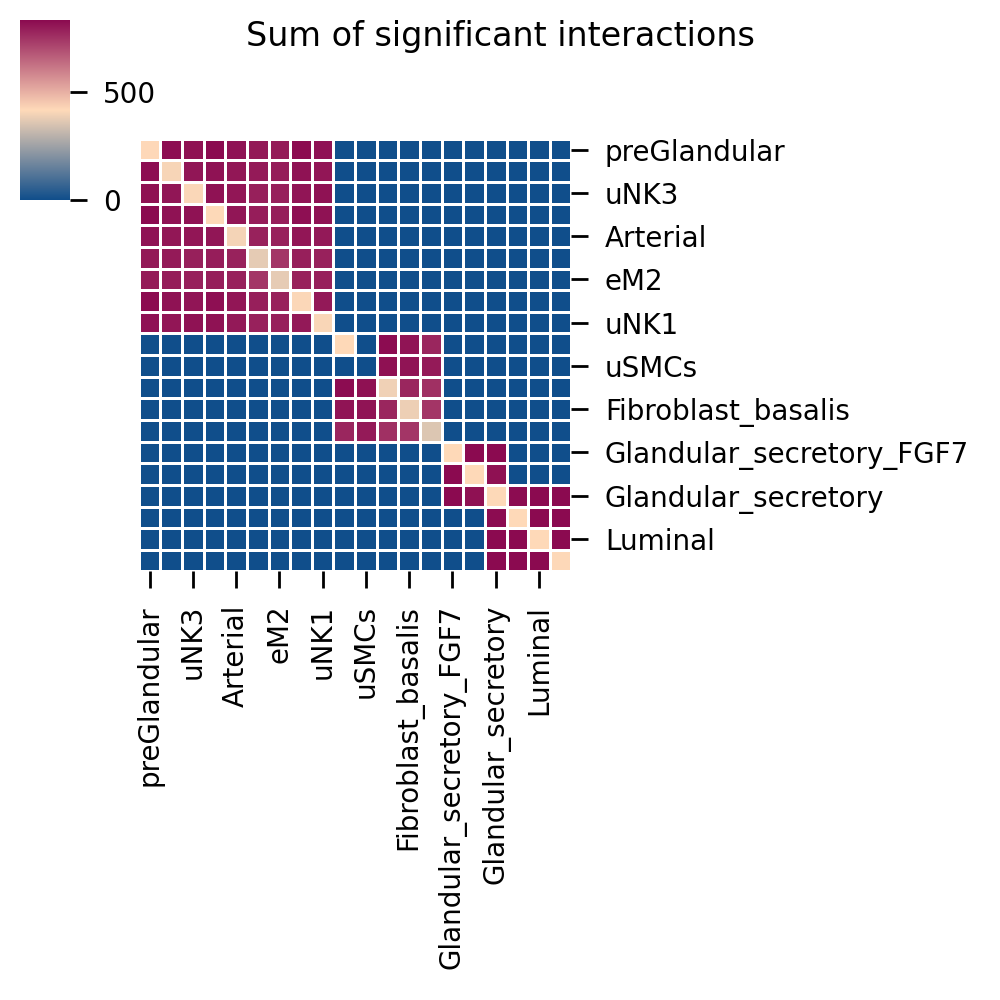

In [46]:
p = kpy.plot_cpdb_heatmap(
    adata=adata,
    pvals=res['relevant_interactions_result'],
    celltype_key="celltype",
    figsize=(5, 5),
    title="Sum of significant interactions",
    symmetrical=True,
)
p
import matplotlib.pyplot as plt
plt.show()